<a href="https://colab.research.google.com/github/elizabethts/DS-Unit-1-Sprint-1-Dealing-With-Data/blob/master/LS_DS_114_Making_Data_backed_Assertions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lambda School Data Science - Making Data-backed Assertions

This is, for many, the main point of data science - to create and support reasoned arguments based on evidence. It's not a topic to master in a day, but it is worth some focused time thinking about and structuring your approach to it.

## Lecture - generating a confounding variable

The prewatch material told a story about a hypothetical health condition where both the drug usage and overall health outcome were related to gender - thus making gender a confounding variable, obfuscating the possible relationship between the drug and the outcome.

Let's use Python to generate data that actually behaves in this fashion!

In [0]:
import random
dir(random)  # Reminding ourselves what we can do here
random.seed(10) # Sets Random Seed for Reproducibility

In [2]:
# Let's think of another scenario:
# We work for a company that sells accessories for mobile phones.
# They have an ecommerce site, and we are supposed to analyze logs
# to determine what sort of usage is related to purchases, and thus guide
# website development to encourage higher conversion.

# The hypothesis - users who spend longer on the site tend
# to spend more. Seems reasonable, no?

# But there's a confounding variable! If they're on a phone, they:
# a) Spend less time on the site, but
# b) Are more likely to be interested in the actual products!

# Let's use namedtuple to represent our data

from collections import namedtuple
# purchased and mobile are bools, time_on_site in seconds
User = namedtuple('User', ['purchased','time_on_site', 'mobile'])

example_user = User(False, 12, False)
print(example_user)

User(purchased=False, time_on_site=12, mobile=False)


In [3]:
# And now let's generate 1000 example users
# 750 mobile, 250 not (i.e. desktop)
# A desktop user has a base conversion likelihood of 10%
# And it goes up by 1% for each 15 seconds they spend on the site
# And they spend anywhere from 10 seconds to 10 minutes on the site (uniform)
# Mobile users spend on average half as much time on the site as desktop
# But have three times as much base likelihood of buying something

users = []

for _ in range(250):
  # Desktop users
  time_on_site = random.uniform(10, 600)
  purchased = random.random() < 0.1 + (time_on_site / 1500)
  users.append(User(purchased, time_on_site, False))
  
for _ in range(750):
  # Mobile users
  time_on_site = random.uniform(5, 300)
  purchased = random.random() < 0.3 + (time_on_site / 1500)
  users.append(User(purchased, time_on_site, True))
  
random.shuffle(users)
print(users[:10])

[User(purchased=False, time_on_site=172.07500125969045, mobile=False), User(purchased=False, time_on_site=242.1604565076447, mobile=True), User(purchased=True, time_on_site=172.4562884302345, mobile=True), User(purchased=False, time_on_site=134.30741730988564, mobile=True), User(purchased=False, time_on_site=176.6659151415657, mobile=False), User(purchased=False, time_on_site=98.57704667574383, mobile=True), User(purchased=False, time_on_site=141.90635886960914, mobile=True), User(purchased=False, time_on_site=46.30954508769639, mobile=True), User(purchased=True, time_on_site=568.9570603645093, mobile=False), User(purchased=False, time_on_site=64.57737234489078, mobile=True)]


In [4]:
# Let's put this in a dataframe so we can look at it more easily
import pandas as pd
user_data = pd.DataFrame(users)
user_data.head()

,purchased,time_on_site,mobile
0,False,172.075001,False
1,False,242.160457,True
2,True,172.456288,True
3,False,134.307417,True
4,False,176.665915,False


In [5]:
user_data.dtypes

purchased          bool
time_on_site    float64
mobile             bool
dtype: object

In [6]:
user_data.isnull().sum()

purchased       0
time_on_site    0
mobile          0
dtype: int64

In [7]:
user_data.describe()

,time_on_site
count,1000.000000
mean,189.808593
std,127.484370
min,5.167894
25%,94.523032
50%,175.663445
75%,255.629865
max,599.904400


In [8]:
import numpy as np
user_data.describe(exclude=[np.number])

,purchased,mobile
count,1000,1000
unique,2,2
top,False,True
freq,644,750


In [9]:
# Let's use crosstabulation to try to see what's going on
pd.crosstab(user_data['purchased'], user_data['time_on_site'])

time_on_site,5.167894147962072,5.230051694531813,5.859655940198439,6.0175026563650755,6.029351938631506,6.076534025386882,7.530625255773601,7.817115390608255,7.825127435732432,7.9926238138229575,8.340271367612646,8.606832008318156,9.218381144065109,10.058796842584638,10.05973343102422,10.098880952488393,10.269710128673584,10.624743380825596,10.775511794102913,10.837439718435094,10.847332077574741,11.300954145638592,11.66995174259849,11.675545744100827,11.782873882183889,11.841426573214946,12.392535053460403,12.40665438918597,12.92898208568828,12.955059196515535,12.996416835255978,13.382120427301592,13.54511635197098,13.934746202094221,14.137459282045185,15.38873657245532,16.922971203004536,17.353027809843624,17.447706834056127,17.662245360895042,...,482.6472145022762,485.9266783851125,486.4774281431866,489.8595383008188,492.78513492217877,495.15954119502254,497.0189957498146,499.3596843687688,502.23256501573536,503.5096132803155,510.3106040801197,513.7199567827874,514.524187056424,516.4726132592837,517.4950119989117,518.7549370475441,523.0318717844676,524.0890952881243,541.9178996100884,547.2149524114925,553.3795732755347,563.7377598676529,565.1913401235421,568.9570603645093,569.1394152918596,570.4001379889107,571.1747962145259,576.1168783345762,576.2458375079051,581.5998993123494,582.0038712877167,585.1679472229359,588.9784218509578,589.6238169166027,594.952201290341,595.4861528820476,595.6859588006147,597.9686255982785,599.821842253337,599.9043999383127
purchased,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
False,0,1,1,0,1,1,1,1,1,0,1,1,1,1,1,1,1,1,0,1,1,0,1,1,0,1,1,1,1,1,1,1,0,0,1,1,0,1,1,0,...,0,1,1,1,0,0,1,1,1,0,1,1,0,0,1,1,1,1,1,1,1,0,0,0,0,0,0,1,0,0,1,1,0,1,1,1,0,0,1,0
True,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,1,1,0,0,1,0,0,1,...,1,0,0,0,1,1,0,0,0,1,0,0,1,1,0,0,0,0,0,0,0,1,1,1,1,1,1,0,1,1,0,0,1,0,0,0,1,1,0,1


In [10]:
# !pip freeze # 0.24.2
!pip install pandas==0.23.4

In [11]:
!pip freeze

absl-py==0.7.1
alabaster==0.7.12
albumentations==0.1.12
altair==3.0.1
astor==0.8.0
astropy==3.0.5
atari-py==0.1.15
atomicwrites==1.3.0
attrs==19.1.0
audioread==2.1.7
autograd==1.2
Babel==2.6.0
backcall==0.1.0
backports.tempfile==1.0
backports.weakref==1.0.post1
beautifulsoup4==4.6.3
bleach==3.1.0
blis==0.2.4
bokeh==1.0.4
boto==2.49.0
boto3==1.9.156
botocore==1.12.156
Bottleneck==1.2.1
branca==0.3.1
bs4==0.0.1
bz2file==0.98
cachetools==3.1.1
certifi==2019.3.9
cffi==1.12.3
chainer==5.4.0
chardet==3.0.4
Click==7.0
cloudpickle==0.6.1
cmake==3.12.0
colorlover==0.3.0
community==1.0.0b1
contextlib2==0.5.5
convertdate==2.1.3
coverage==3.7.1
coveralls==0.5
crcmod==1.7
cufflinks==0.14.6
cvxopt==1.2.3
cvxpy==1.0.15
cycler==0.10.0
cymem==2.0.2
Cython==0.29.7
cytoolz==0.9.0.1
daft==0.0.4
dask==1.1.5
dataclasses==0.6
datascience==0.10.6
decorator==4.4.0
defusedxml==0.6.0
dill==0.2.9
distributed==1.25.3
Django==2.2.1
dlib==19.16.0
dm-sonnet==1.32
docopt==0.6.2
docutils==0.14
dopamine-rl==1.0.5
easydi

In [12]:
# OK, that's not quite what we want
# Time is continuous! We need to put it in discrete buckets
# Pandas calls these bins, and pandas.cut helps make them

time_bins = pd.cut(user_data['time_on_site'], 6)  # 6 equal-sized bins
pd.crosstab(user_data['purchased'], time_bins)

time_on_site,"(4.573, 104.291]","(104.291, 203.413]","(203.413, 302.536]","(302.536, 401.659]","(401.659, 500.782]","(500.782, 599.904]"
purchased,,,,,,
False,207,180,169,41,30,17
True,77,109,133,10,12,15


In [13]:
# We can make this a bit clearer by normalizing (getting %)
pd.crosstab(user_data['purchased'], time_bins, normalize='columns')

time_on_site,"(4.573, 104.291]","(104.291, 203.413]","(203.413, 302.536]","(302.536, 401.659]","(401.659, 500.782]","(500.782, 599.904]"
purchased,,,,,,
False,0.728873,0.622837,0.559603,0.803922,0.714286,0.53125
True,0.271127,0.377163,0.440397,0.196078,0.285714,0.46875


In [14]:
# That seems counter to our hypothesis
# More time on the site can actually have fewer purchases

# But we know why, since we generated the data!
# Let's look at mobile and purchased
pd.crosstab(user_data['purchased'], user_data['mobile'], normalize='columns')

mobile,False,True
purchased,,
False,0.728,0.616
True,0.272,0.384


In [15]:
# Yep, mobile users are more likely to buy things
# But we're still not seeing the *whole* story until we look at all 3 at once

# Live/stretch goal - how can we do that?

ct = pd.crosstab(user_data['mobile'], [user_data['purchased'], time_bins],
                 rownames = ['device'],
                 colnames = ['purchased','time_on_site'],
                 normalize = 'index'
                )
ct


purchased               False        ...                      True 
time_on_site (4.573, 104.291]        ...         (500.782, 599.904]
device                               ...                           
False                   0.132        ...                       0.06
True                    0.232        ...                       0.00

[2 rows x 12 columns]

In [16]:
type(ct)

pandas.core.frame.DataFrame

In [17]:
pt = pd.pivot_table(user_data, values = 'purchased', index = time_bins)
pt

,purchased
time_on_site,
"(4.573, 104.291]",0.271127
"(104.291, 203.413]",0.377163
"(203.413, 302.536]",0.440397
"(302.536, 401.659]",0.196078
"(401.659, 500.782]",0.285714
"(500.782, 599.904]",0.468750


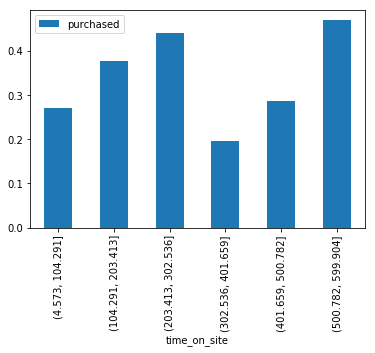

In [18]:
pt.plot.bar();

In [19]:
ct = pd.crosstab(time_bins, [user_data['purchased'], user_data['mobile']], 
                normalize = 'columns')
ct

purchased              False               True           
mobile                 False     True      False     True 
time_on_site                                              
(4.573, 104.291]    0.181319  0.376623  0.073529  0.250000
(104.291, 203.413]  0.142857  0.333333  0.161765  0.340278
(203.413, 302.536]  0.192308  0.290043  0.220588  0.409722
(302.536, 401.659]  0.225275  0.000000  0.147059  0.000000
(401.659, 500.782]  0.164835  0.000000  0.176471  0.000000
(500.782, 599.904]  0.093407  0.000000  0.220588  0.000000

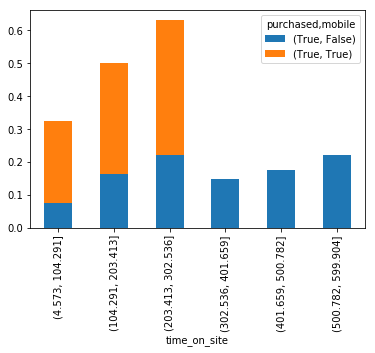

In [20]:
ct_final = ct.iloc[:, [2,3]]
ct_final.plot(kind = 'bar', stacked = True);

## Assignment - what's going on here?

Consider the data in `persons.csv` (already prepared for you, in the repo for the week). It has four columns - a unique id, followed by age (in years), weight (in lbs), and exercise time (in minutes/week) of 1200 (hypothetical) people.

Try to figure out which variables are possibly related to each other, and which may be confounding relationships.

In [0]:
import matplotlib.pyplot as plt

In [26]:
# TODO - your code here
# Use what we did live in lecture as an example

# HINT - you can find the raw URL on GitHub and potentially use that
# to load the data with read_csv, or you can upload it yourself


#load data
persons_url = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-1-Sprint-1-Dealing-With-Data/master/module3-databackedassertions/persons.csv'
persons_df = pd.read_csv(persons_url)
persons_df.head()

,Unnamed: 0,age,weight,exercise_time
0,0,44,118,192
1,1,41,161,35
2,2,46,128,220
3,3,39,216,57
4,4,28,116,182


In [22]:
persons_df.shape 

(1200, 4)

In [23]:
time_range = pd.cut(persons_df['exercise_time'],30) #cut time into 5 groups
age_range = pd.cut(persons_df['age'],3) #cut time into 5 groups
weight_range = pd.cut(persons_df['weight'],30)
persons_ct = pd.crosstab(persons_df['weight'], 
                         [age_range, persons_df['exercise_time']])
persons_ct

age           (17.938, 38.667]                     ... (59.333, 80.0]                    
exercise_time              0   2   3   4   5   6   ...            246 249 255 265 284 298
weight                                             ...                                   
100                          0   0   0   0   0   0 ...              0   0   0   0   0   0
101                          0   0   0   0   0   0 ...              0   0   0   0   0   0
102                          0   0   0   0   0   0 ...              0   0   0   0   0   0
103                          0   0   0   0   0   0 ...              0   0   0   0   0   0
104                          0   0   0   0   0   0 ...              0   0   0   0   0   0
105                          0   0   0   0   0   0 ...              0   0   0   0   0   0
106                          0   0   0   0   0   0 ...              0   0   0   0   0   0
107                          0   0   0   0   0   0 ...              0   0   0   0   0   0
108                          0   0   0   0   0   0 ...              0   0   0   0   0   0
109                          0   0   0   0   0   0 ...              0   0   0   0   0   0
110                          0   0   0   0   0   0 ...              0   0   0   0   1   0
111                          0   0   0   0   0   0 ...              0   0   0   0   0   0
112                          0   0   0   0   0   0 ...              0   0   0   0   0   0
113                          0   0   0   0   0   0 ...              0   0   0   0   0   0
114                          0   0   0   0   0   0 ...              0   0   0   0   0   0
115                          0   0   0   0   0   0 ...              0   0   0   0   0   0
116                          0   0   0   0   0   0 ...              0   0   0   0   0   0
117                          0   0   0   0   0   0 ...              0   0   0   0   0   0
118                          0   0   0   0   0   0 ...              0   0   0   0   0   0
119                          0   0   0   0   0   0 ...              0   0   0   0   0   0
120                          0   0   0   0   0   0 ...              0   0   0   0   0   0
121                          0   0   0   0   0   0 ...              0   0   0   0   0   0
122                          0   0   0   0   0   0 ...              0   0   0   0   0   0
123                          0   0   0   0   0   0 ...              0   0   0   0   0   0
124                          0   0   0   0   0   0 ...              0   0   0   0   0   0
125                          0   0   0   0   0   0 ...              0   0   0   0   0   0
126                          0   0   0   0   0   0 ...              0   0   0   0   0   0
127                          0   0   0   0   0   0 ...              1   0   0   0   0   0
128                          0   0   0   0   0   0 ...              0   0   0   0   0   0
129                          0   0   0   0   0   0 ...              0   0   0   0   0   0
...                        ...  ..  ..  ..  ..  .. ...            ...  ..  ..  ..  ..  ..
213                          0   0   0   0   0   0 ...              0   0   0   0   0   0
214                          0   0   0   0   0   0 ...              0   0   0   0   0   0
215                          0   0   0   0   0   0 ...              0   0   0   0   0   0
216                          0   0   0   0   0   0 ...              0   0   0   0   0   0
217                          0   0   0   0   0   0 ...              0   0   0   0   0   0
218                          0   0   0   0   0   0 ...              0   0   0   0   0   0
219                          0   0   0   0   0   0 ...              0   0   0   0   0   0
220                          0   0   0   0   0   0 ...              0   0   0   0   0   0
221                          0   0   0   0   0   0 ...              0   0   0   0   0   0
222                          0   0   0   0   0   0 ...              0   0   0   0   0   0
223                          0   0   0  

In [0]:
group1 = persons_df[persons_df.age <30]
group2 = persons_df[(persons_df.age >=30) & (persons_df.age<50)]
group3 = persons_df[persons_df.age >=50]

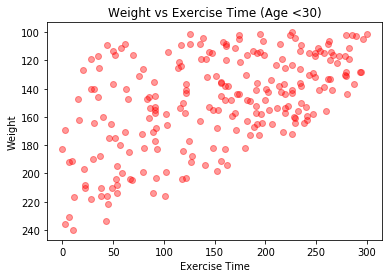

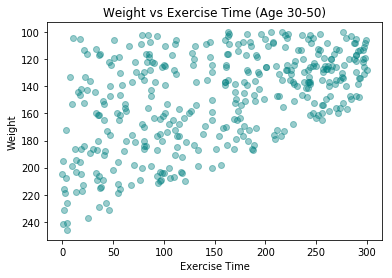

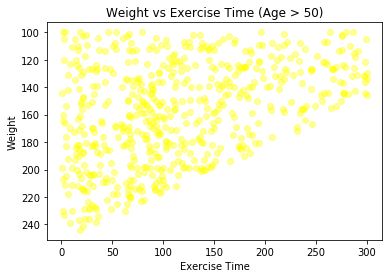

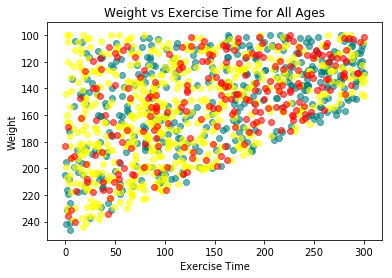

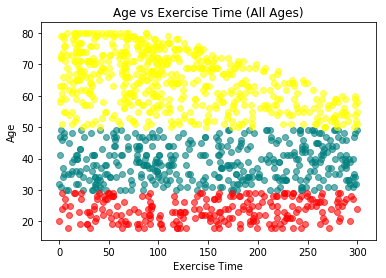

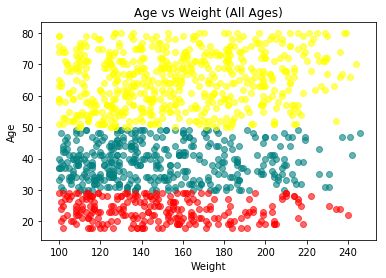

In [28]:
fig, ax1 = plt.subplots()
ax1.set_axisbelow(True)
ax1.set_xlabel('Exercise Time')
ax1.set_ylabel('Weight')
ax1.set_title('Weight vs Exercise Time (Age <30)')
plt.gca().invert_yaxis()
plt.scatter(group1.exercise_time, group1.weight, color ='red', alpha = .4)

fig, ax2 = plt.subplots()
ax2.set_axisbelow(True)
ax2.set_xlabel('Exercise Time')
ax2.set_ylabel('Weight')
ax2.set_title('Weight vs Exercise Time (Age 30-50)')
plt.gca().invert_yaxis()
plt.scatter(group2.exercise_time, group2.weight, color = 'teal', alpha = .4)

fig, ax3 = plt.subplots()
ax3.set_axisbelow(True)
ax3.set_xlabel('Exercise Time')
ax3.set_ylabel('Weight')
ax3.set_title('Weight vs Exercise Time (Age > 50)')
plt.gca().invert_yaxis()
plt.scatter(group3.exercise_time, group3.weight, color = 'yellow', alpha = 0.4);


fig, ax4 = plt.subplots()
ax4.set_axisbelow(True)
ax4.set_xlabel('Exercise Time')
ax4.set_ylabel('Weight')
ax4.set_title('Weight vs Exercise Time for All Ages')
plt.scatter(group2.exercise_time, group2.weight, color = 'teal', alpha = .6)
plt.scatter(group3.exercise_time, group3.weight,color = 'yellow', alpha = 0.6);
plt.scatter(group1.exercise_time, group1.weight, color ='red', alpha = .6)
plt.gca().invert_yaxis()


fig, ax5 = plt.subplots()
ax5.set_axisbelow(True)
ax5.set_xlabel('Exercise Time')
ax5.set_ylabel('Age')
ax5.set_title('Age vs Exercise Time (All Ages)')
plt.scatter(group2.exercise_time, group2.age, color = 'teal', alpha = .6)
plt.scatter(group3.exercise_time, group3.age,color = 'yellow', alpha = 0.6);
plt.scatter(group1.exercise_time, group1.age, color ='red', alpha = .6)

fig, ax6 = plt.subplots()
ax6.set_axisbelow(True)
ax6.set_xlabel('Weight')
ax6.set_ylabel('Age')
ax6.set_title('Age vs Weight (All Ages)')
plt.scatter(group2.weight, group2.age, color = 'teal', alpha = .6)
plt.scatter(group3.weight, group3.age,color = 'yellow', alpha = 0.6);
plt.scatter(group1.weight, group1.age, color ='red', alpha = .6);


In [0]:
#Conclusions: 
#  -People who exercise more weight less
#  -The group age >=50 tends to exercise for a shorter amount of time 

### Assignment questions

After you've worked on some code, answer the following questions in this text block:

1.  What are the variable types in the data?
     
     
     age - ordinal and continuous
     weight - ordinal and continuous
     exercise time - ordinal and continuous

2.  What are the relationships between the variables?
      
      
      Weight decreases as exercise time increases so they are inversely related. Weight increases as age increases so they are directly related

3.  Which relationships are "real", and which spurious?


    The relationship between weight and exercise time is real and the relationship between age and weight is spurious (older people tend to exercise less)


## Stretch goals and resources

Following are *optional* things for you to take a look at. Focus on the above assignment first, and make sure to commit and push your changes to GitHub.

- [Spurious Correlations](http://tylervigen.com/spurious-correlations)
- [NIH on controlling for confounding variables](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4017459/)

Stretch goals:

- Produce your own plot inspired by the Spurious Correlation visualizations (and consider writing a blog post about it - both the content and how you made it)
- Pick one of the techniques that NIH highlights for confounding variables - we'll be going into many of them later, but see if you can find which Python modules may help (hint - check scikit-learn)